![AIcrowd-Logo](https://images.aicrowd.com/raw_images/challenges/banner_file/751/c78e77cc88723e6fcf53.jpg)





<h1> <center>
🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐁🐁🐁🐁🐁🐁🐁🐁🐁🐁<br>
🐀 MABe Classical Classification: Starter kit 🐁<br>
🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐀🐁🐁🐁🐁🐁🐁🐁🐁🐁🐁
</center>
</h1>

<p align="center"><img src="https://images.aicrowd.com/uploads/ckeditor/pictures/324/content_task1_structure.png">
</p>

# How to use this notebook 📝

1. **Copy the notebook**. This is a shared template and any edits you make here will not be saved. _You should copy it into your own drive folder._ For this, click the "File" menu (top-left), then "Save a Copy in Drive". You can edit your copy however you like.
2. **Link it to your AIcrowd account**. In order to submit your predictions to AIcrowd, you need to provide your account's API key.



# Setup AIcrowd Utilities 🛠

In [ ]:
!pip install -U aicrowd-cli==0.1 > /dev/null 

# Import necessary modules and packages 📚


In [1]:
import pandas as pd
import numpy as np
import os

# Download the dataset 📲

Please get your API key from https://www.aicrowd.com/participants/me


In [3]:
API_KEY = "36b33b6e789168f73c953f01912d9a5a"
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [4]:
!aicrowd dataset download --challenge mabe-task-1-classical-classification

train.npy: 100%|█████████████████████████████| 118M/118M [00:17<00:00, 6.84MB/s]


Extract the downloaded dataset to `data` directory


In [5]:
!rm -rf data
!mkdir data
 
!mv train.npy data/train.npy
!mv test-release.npy data/test.npy
!mv sample-submission.npy data/sample_submission.npy

# Load Data
The dataset files are python dictionaries, [this](https://colab.research.google.com/drive/1ddCX-TAdEcsUaGf09f5Glgr_G57FMK_O#scrollTo=JPsfxdl2GMcM&line=18&uniqifier=1) is a descirption of how the data is organized.



In [2]:
train = np.load('data/train.npy',allow_pickle=True).item()
test = np.load('data/test.npy',allow_pickle=True).item()
sample_submission = np.load('data/sample_submission.npy',allow_pickle=True).item()

## Dataset Specifications 💾

-   **`train.npy`** - Training set for the task, which follows the following schema:

<p align="left" style="padding: 30px">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img width="600px" src="https://i.imgur.com/GddvoT2.png">
</p>


-   **`test-release.npy`** - Test set for the task, which follows the following schema :

<p align="left" style="padding: 30px">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img width="600px" src="https://i.imgur.com/vfa8Y4V.png">
</p>

-   **`sample_submission.npy`** - Template for a sample submission which follows the following schema

```json
{
    "<sequence_id-1>" : [0, 0, 1, 2, ...],
    "<sequence_id-2>" : [0, 1, 2, 0, ...]
}
```

Each key in the dictionary here refers to the unique sequence id obtained for the sequences in the test set.
The value for each of the keys is expected to hold a list of corresponing annotations. The annotations are represented by the index of the corresponding annotation words in the vocabular provided in the test set.

## How does the data look like? 🔍

### Data overview

In [5]:
print("Dataset keys - ", train.keys())
print("Vocabulary - ", train['vocabulary'])
print("Number of train Sequences - ", len(train['sequences']))


Dataset keys -  dict_keys(['vocabulary', 'sequences'])
Vocabulary -  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
Number of train Sequences -  70


### Sample overview

In [6]:
sequence_names = list(train["sequences"].keys())
sequence_key = sequence_names[0]
single_sequence = train["sequences"][sequence_key]
print("Sequence name - ", sequence_key)
print("Single Sequence keys ", single_sequence.keys())
print(f"Number of Frames in {sequence_key} - ", len(single_sequence['annotations']))
print(f"Keypoints data shape of {sequence_key} - ", single_sequence['keypoints'].shape)
print(f"annotator_id of {sequence_key} - ", single_sequence['annotator_id'])

Sequence name -  1cac195d39
Single Sequence keys  dict_keys(['keypoints', 'annotator_id', 'annotations'])
Number of Frames in 1cac195d39 -  4879
Keypoints data shape of 1cac195d39 -  (4879, 2, 2, 7)
annotator_id of 1cac195d39 -  0


# Helper function for visualization 💁
Don't forget to run the cell 😉

In [7]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
 
rc('animation', html='jshtml')

# Note: Image processing may be slow if too many frames are animated.                

#Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570
 
RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'
 
PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]
 
class_to_color = {'other': 'white', 'attack' : 'red', 'mount' : 'green',
                  'investigation': 'orange'}
 
class_to_number = {s: i for i, s in enumerate(train['vocabulary'])}

number_to_class = {i: s for i, s in enumerate(train['vocabulary'])}

def num_to_text(anno_list, number_to_class):
    return np.vectorize(number_to_class.get)(anno_list)


def set_figax():
    fig = plt.figure(figsize=(6, 4))
 
    img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))

    ax = fig.add_subplot(111)
    ax.imshow(img)
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    return fig, ax
 
def plot_mouse(ax, pose, color):
    # Draw each keypoint
    for j in range(7):
        ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)
 
    # Draw a line for each point pair to form the shape of the mouse
 
    for pair in PLOT_MOUSE_START_END:
        line_to_plot = pose[pair, :]
        ax.plot(line_to_plot[:, 0], line_to_plot[
                :, 1], color=color, linewidth=1)
 
def animate_pose_sequence(video_name, keypoint_sequence, number_to_class, start_frame = 0, stop_frame = 100,
                          annotation_sequence = None):
    # Returns the animation of the keypoint sequence between start frame
    # and stop frame. Optionally can display annotations.
    seq = keypoint_sequence.transpose((0,1,3,2))
 
    image_list = []
    
    counter = 0
    for j in range(start_frame, stop_frame):
        if counter%20 == 0:
          print("Processing frame ", j)
        fig, ax = set_figax()
        plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
        plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)
        
        if annotation_sequence is not None:
          annot = annotation_sequence[j]
          annot = number_to_class[annot]
          plt.text(50, -20, annot, fontsize = 16, 
                   bbox=dict(facecolor=class_to_color[annot], alpha=0.5))
 
        ax.set_title(
            video_name + '\n frame {:03d}.png'.format(j))
 
        ax.axis('off')
        fig.tight_layout(pad=0)
        ax.margins(0)
 
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                        dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)) 
 
        image_list.append(image_from_plot)
 
        plt.close()
        counter = counter + 1
 
    # Plot animation.
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(image_list[0])
 
    def animate(k):
        im.set_array(image_list[k])
        return im,
    ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
    return ani
 
def plot_annotation_strip(annotation_sequence, start_frame = 0, stop_frame = 100, title="Behavior Labels"):
  # Plot annotations as a annotation strip.
 
  # Map annotations to a number.
  annotation_num = []
  for item in annotation_sequence[start_frame:stop_frame]:
    annotation_num.append(class_to_number[item])
 
  all_classes = list(set(annotation_sequence[start_frame:stop_frame]))
 
  cmap = colors.ListedColormap(['red', 'orange', 'green', 'white'])
  bounds=[-0.5,0.5,1.5, 2.5, 3.5]
  norm = colors.BoundaryNorm(bounds, cmap.N)
 
  height = 200
  arr_to_plot = np.repeat(np.array(annotation_num)[:,np.newaxis].transpose(),
                                                  height, axis = 0)
  
  fig, ax = plt.subplots(figsize = (16, 3))
  ax.imshow(arr_to_plot, interpolation = 'none',cmap=cmap, norm=norm)
 
  ax.set_yticks([])
  ax.set_xlabel('Frame Number')
  plt.title(title)
 
  import matplotlib.patches as mpatches
 
  legend_patches = []
  for item in all_classes:
    legend_patches.append(mpatches.Patch(color=class_to_color[item], label=item))
 
  plt.legend(handles=legend_patches,loc='center left', bbox_to_anchor=(1, 0.5))
 
  plt.tight_layout()

# Visualize the mouse movements🎥

Sample visualization for plotting pose gifs.

Processing frame  3000
Processing frame  3020
Processing frame  3040
Processing frame  3060
Processing frame  3080


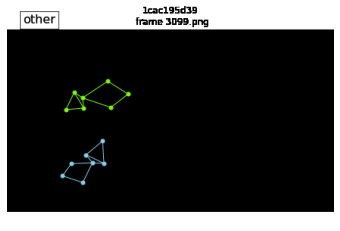

In [24]:
keypoint_sequence = single_sequence['keypoints']
annotation_sequence = single_sequence['annotations']

ani = animate_pose_sequence(sequence_key,
                            keypoint_sequence, number_to_class,
                            start_frame = 3000,
                            stop_frame = 3100,
                            annotation_sequence = annotation_sequence)

# Display the animaion on colab
ani

### Showing a section of the validation data (Index needs to be selected for a full video)

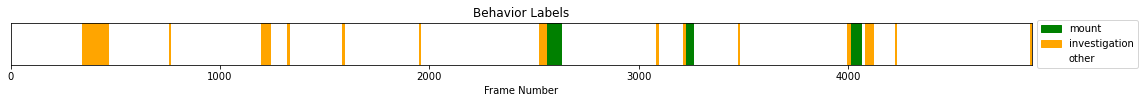

In [9]:
annotation_sequence = single_sequence['annotations']
text_sequence = num_to_text(annotation_sequence, number_to_class)
 
plot_annotation_strip(
    text_sequence,
    start_frame=0,
    stop_frame=len(annotation_sequence) + 1000
)

# Basic EDA 🤓
Each sequence has different amounts of each behavior, here we get the percentage of frames of each behavior in each sequence. We can use this to split the dataset for validation in a stratified way.

In [10]:
vocabulary = train['vocabulary']
def get_percentage(sequence_key, train, vocabulary):
  anno_seq = num_to_text(train['sequences'][sequence_key]['annotations'], number_to_class)
  counts = {k: np.mean(np.array(anno_seq) == k) for k in vocabulary}
  return counts

anno_percentages = {k: get_percentage(k,train, vocabulary) for k in train['sequences']}

anno_perc_df = pd.DataFrame(anno_percentages).T
print("Percentage of frames in every sequence for every class")
anno_perc_df.head()

Percentage of frames in every sequence for every class


attack  investigation     mount     other
1cac195d39  0.000000       0.077885  0.033818  0.888297
b40d39ca72  0.000000       0.625136  0.000000  0.374864
f45694e6b9  0.000000       0.375125  0.000000  0.624875
9212f26324  0.015467       0.112307  0.000000  0.872226
5490af36aa  0.438260       0.285662  0.010321  0.265757

## Percentage Frames of all behaviors
Lets look at the class imbalance

# 

In [11]:
all_annotations = []
for sk in train['sequences']:
  anno = train['sequences'][sk]['annotations']
  all_annotations.extend(list(anno))
all_annotations = num_to_text(all_annotations, number_to_class)
classes, counts = np.unique(all_annotations, return_counts=True)
pd.DataFrame({"Behavior": classes,
              "Percentage Frames": counts/len(all_annotations)})

Behavior  Percentage Frames
0         attack           0.027658
1  investigation           0.288777
2          mount           0.056372
3          other           0.627194

In [50]:
from scipy.spatial.distance import cdist
import numpy as np

body_parts = 7
fps = 30


def extract_features(data, train=False):
    '''
    Extracting the data and reshaping it. It returns a dictionary indexed by seq_id, the value of which corresponds
     to the flattened data, therefore an (n_frames x 28) matrix at this point. Labels are only extracted if we're
     training data, otherwise the annotation dictionary will be empty '''

    data_dict = {}
    anno_dict = {}
    sequence_train_names = list(data["sequences"].keys())
    for sequence_key in sequence_train_names :
        single_sequence = data["sequences"][sequence_key]
        # features Dimensions: (# frames) x (mouse ID) x (x, y coordinate) x (body part)
        keypoints = single_sequence["keypoints"]
        n_frames = keypoints.shape[0]
        data_dict[sequence_key] = np.reshape(keypoints, (n_frames, 28))
        if train:
            anno_dict[sequence_key] = data["sequences"][sequence_key]['annotations']
    return data_dict, anno_dict


In [51]:
data, labels = extract_features(train, train=True)

In [52]:
pd.DataFrame(data.get('1cac195d39'))

0           1           2           3           4           5   \
0     298.993678  266.993678  248.993678  243.993678  181.993678  144.993678   
1     295.167458  272.167458  258.167458  250.167458  188.167458  155.167458   
2     301.360918  278.360918  264.360918  256.360918  203.360918  158.360918   
3     301.279237  283.279237  269.279237  261.279237  214.279237  158.279237   
4     314.116591  292.116591  277.116591  272.116591  221.116591  168.116591   
...          ...         ...         ...         ...         ...         ...   
4874  249.866255  263.866255  305.866255  295.866255  351.866255  360.866255   
4875  262.801506  265.801506  319.801506  297.801506  327.801506  367.801506   
4876  265.164439  264.164439  319.164439  295.164439  319.164439  364.164439   
4877  254.539417  256.539417  307.539417  289.539417  312.539417  360.539417   
4878  235.992181  248.992181  296.992181  279.992181  317.992181  361.992181   

              6           7           8           9   ...          18  \
0     125.993678  140.750941  194.750941  138.750941  ...  235.689427   
1     132.167458  139.060320  185.060320  133.060320  ...  233.571692   
2     140.360918  135.643521  178.643521  130.643521  ...  231.119408   
3     150.279237  134.841073  170.841073  125.841073  ...  230.141740   
4     157.116591  126.012383  164.012383  123.012383  ...  234.022800   
...          ...         ...         ...         ...  ...         ...   
4874  415.866255  241.709793  183.709793  225.709793  ...  135.517000   
4875  410.801506  263.084053  208.084053  238.084053  ...  135.388774   
4876  406.164439  290.183461  233.183461  254.183461  ...  134.131664   
4877  400.539417  313.828905  251.828905  278.828905  ...  135.975401   
4878  392.992181  328.423868  270.423868  303.423868  ...  135.353877   

              19          20          21          22          23          24  \
0     161.689427  203.689427  283.872987  323.872987  329.872987  342.872987   
1     159.571692  202.571692  276.832877  321.832877  326.832877  340.832877   
2     159.119408  203.119408  271.252561  321.252561  325.252561  340.252561   
3     156.141740  202.141740  269.633701  323.633701  323.633701  338.633701   
4     157.022800  201.022800  269.935361  323.935361  319.935361  338.935361   
...          ...         ...         ...         ...         ...         ...   
4874   77.517000  101.517000  228.339301  282.339301  219.339301  259.339301   
4875   79.388774  103.388774  229.682083  281.682083  219.682083  259.682083   
4876   78.131664  102.131664  232.485780  285.485780  220.485780  261.485780   
4877   78.975401  101.975401  232.115089  282.115089  221.115089  261.115089   
4878   80.353877  104.353877  232.067077  282.067077  220.067077  261.067077   

              25          26          27  
0     429.872987  433.872987  487.872987  
1     429.832877  433.832877  488.832877  
2     429.252561  434.252561  488.252561  
3     431.633701  433.633701  487.633701  
4     429.935361  430.935361  485.935361  
...          ...         ...         ...  
4874  320.339301  290.339301  337.339301  
4875  319.682083  290.682083  337.682083  
4876  320.485780  289.485780  338.485780  
4877  319.115089  295.115089  338.115089  
4878  319.067077  298.067077  338.067077  

[4879 rows x 28 columns]

# Interpolation

In [53]:
def interpolate_frame(data, label_dict, n):
    sequence_train_names = list(data.keys())
    for sequence_key in sequence_train_names:
        single_sequence = pd.DataFrame(data[sequence_key])
        single_sequence['annotations'] = label_dict[sequence_key]

        new_index = pd.RangeIndex(len(single_sequence) * (n + 1))
        single_sequence_ext = pd.DataFrame(np.nan, index=new_index, columns=single_sequence.columns)
        ids = np.arange(len(single_sequence)) * (n + 1)
        single_sequence_ext.loc[ids] = single_sequence.values
        single_sequence_ext.drop(single_sequence_ext.index[-n:], inplace=True)
        single_sequence_ext['annotations'].interpolate('backfill', inplace=True)
        single_sequence_ext.interpolate('quadratic', inplace=True)

        data[sequence_key] = single_sequence_ext.loc[:, single_sequence_ext.columns!='annotations'].to_numpy()
        label_dict[sequence_key] = single_sequence_ext.loc[:, single_sequence_ext.columns=='annotations'].to_numpy().flatten()
    return data, label_dict

In [54]:
data, labels = interpolate_frame(data,labels,2)

Processing frame  9000
Processing frame  9020
Processing frame  9040
Processing frame  9060
Processing frame  9080
Processing frame  9100
Processing frame  9120
Processing frame  9140
Processing frame  9160
Processing frame  9180
Processing frame  9200
Processing frame  9220
Processing frame  9240
Processing frame  9260
Processing frame  9280


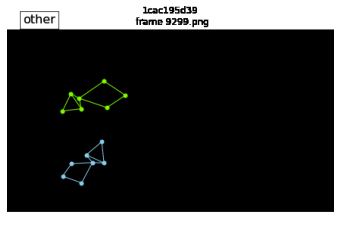

In [58]:
keypoint_sequence = data.get('1cac195d39').reshape(14635,2,2,7)
annotation_sequence = labels.get('1cac195d39')

ani = animate_pose_sequence('1cac195d39',
                            keypoint_sequence, number_to_class,
                            start_frame = 9000,
                            stop_frame = 9300,
                            annotation_sequence = annotation_sequence)

ani 

Processing frame  3000
Processing frame  3020
Processing frame  3040
Processing frame  3060
Processing frame  3080


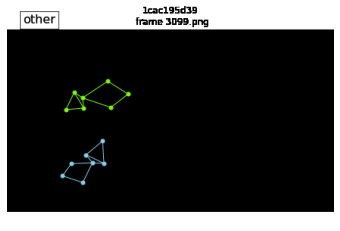

In [59]:
keypoint_sequence = single_sequence['keypoints']
annotation_sequence = single_sequence['annotations']

ani = animate_pose_sequence(sequence_key,
                            keypoint_sequence, number_to_class,
                            start_frame = 3000,
                            stop_frame = 3100,
                            annotation_sequence = annotation_sequence)

# Display the animaion on colab
ani

# Bounding boxes


In [30]:
def bounding_box(data):
    ''' Adds a feature which corresponds to the area of intersection between the mice based on the two rectangles
    that are defined by their position in the space '''
    sequence_train_names = list(data.keys())
    for sequence_key in sequence_train_names :
        single_sequence = data[sequence_key].copy()
        out = np.zeros((single_sequence.shape[0], 29))

        mouse1_x = single_sequence[:, 0:7]
        mouse1_y = single_sequence[:, 7:14]
        mouse2_x = single_sequence[:, 14:21]
        mouse2_y = single_sequence[:, 21:28]

        x_min_1 = np.min(mouse1_x, axis=1)
        y_min_1 = np.min(mouse1_y, axis=1)
        x_max_1 = np.max(mouse1_x, axis=1)
        y_max_1 = np.min(mouse1_y, axis=1)

        x_min_2 = np.min(mouse2_x, axis=1)
        y_min_2 = np.min(mouse2_y, axis=1)
        x_max_2 = np.max(mouse2_x, axis=1)
        y_max_2 = np.min(mouse2_y, axis=1)

        dx = np.minimum(x_max_1, x_max_2) - np.maximum(x_min_1, x_min_2)
        dy = np.minimum(y_max_1, y_max_2) - np.maximum(y_min_1, y_min_2)
        int_area = np.abs(dx*dy)
        int_area[(dx<0) & (dy<0)] = 0
        out[:, 0:28] = single_sequence[:, 0:28]
        out[:, 28] = int_area
        data[sequence_key] = out
    return data

In [34]:
data = bounding_box(data)




# Center of mass and mouse extension

In [35]:
def center_of_mass(data):
    sequence_train_names = data.keys()
    for sequence_key in sequence_train_names:
        single_sequence = data[sequence_key]
        shape = single_sequence.shape
        data[sequence_key] = np.zeros((shape[0], 36))
        # keypoints = single_sequence["keypoints"]
        # n_frames = single_sequence.shape[0]
        mouse1_x = single_sequence[:, 0:7]
        mouse1_y = single_sequence[:, 7:14]
        mouse2_x = single_sequence[:, 14:21]
        mouse2_y = single_sequence[:, 21:28]
        mouse1_center = np.vstack([np.average(mouse1_x, axis=1), np.average(mouse1_y, axis=1)]).T
        mouse2_center = np.vstack([np.average(mouse2_x, axis=1), np.average(mouse2_y, axis=1)]).T
        mouse1_dispersion = np.average(
            np.sqrt(np.square(mouse1_x - mouse1_center[:, 0:1]) + np.square(mouse1_y - mouse1_center[:, 1:2])), axis=1)
        mouse2_dispersion = np.average(
            np.sqrt(np.square(mouse2_x - mouse2_center[:, 0:1]) + np.square(mouse2_y - mouse2_center[:, 1:2])), axis=1)
        distance_between_centers = np.sqrt(np.sum(np.square(mouse1_center - mouse2_center), axis=1))
        data[sequence_key][:, 0:29] = single_sequence[:, 0:29]
        data[sequence_key][:, 29:31] = mouse1_center
        data[sequence_key][:, 31:33] = mouse2_center
        data[sequence_key][:, 33] = mouse1_dispersion
        data[sequence_key][:, 34] = mouse2_dispersion
        data[sequence_key][:, 35] = distance_between_centers
    return data

In [36]:
data = center_of_mass(data)